In [1]:
import os 
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# Preparing the Data 

animals10 from: https://www.kaggle.com/alessiocorrado99/animals10

landscape from: https://www.kaggle.com/arnaud58/landscape-pictures

In [2]:
# load half animal images, half landscape images
# equal amount of each animal represented
def load_data(n):
    dirnames = os.listdir('animals10/raw-img/')
    if '.DS_Store' in dirnames:
        dirnames.remove('.DS_Store')
    """
    translateTo = {"cane": 0, "cavallo": 1, "elefante": 2, "farfalla": 3, "gallina": 4, "gatto": 5, 
                   "mucca": 6, "pecora": 7, "ragno": 8, "scoiattolo": 9}
    translateFrom = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", 
                     "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "ragno": "spider", 
                     "scoiattolo": "squirrel"}
    """
    
    image_array = []
    type_array = []
    skipped = 0
    
    for dire in dirnames: # loops through all animal type folders
        directory = 'animals10/raw-img/' + dire
        category = os.listdir(directory)
        i = 0
        
        for image in category: # collects n / 10 images from each animal folder
            img = cv.imread(directory + '/' + image,3)
            b,g,r = cv.split(img) # this fixes odd coloring
            img = cv.merge([r,g,b])
            img = cv.resize(img, (200, 200))
            """
            if (img.shape[0] > 500) or (img.shape[1] > 700): # this is for making sure all images are same size
                print(img.shape) 
                skipped +=1
                continue
            img = np.pad(img, [(0,500 - img.shape[0]),(0,700 - img.shape[1]),(0,0)],mode='constant')
            """
            image_array.append(img)
            type_array.append(1)
            i += 1
            if(i == int(n/10)): # end loop if quota of images is met
                break
                
    directory = os.listdir('landscape')
    i = 0
    for image in directory: # collecting images from landscape file
        img = cv.imread('landscape/' + image,3)  
        b,g,r = cv.split(img) # this fixes odd coloring
        img = cv.merge([r,g,b])
        img = cv.resize(img, (200, 200))
        image_array.append(img)
        type_array.append(0)
        i += 1
        if(i == n):
            break
    image_array = np.array(image_array)
    type_array = np.array(type_array)
    #print(str(skipped) + " images were skipped")
    return image_array, type_array

In [3]:
X,y = load_data(500)

In [4]:
#this is the shuffle and split function I wrote for assignment 1, but modified for validation set
# 80% training, 10% validation, 10% testing will be used
def train_val_test_split(X,y):
    ind = np.arange(len(X))
    np.random.shuffle(ind)
    train_val_split_at = int(8 * len(X) / 10)
    val_test_split_at = int(9 * len(X) / 10)
    train_ind = ind[:train_val_split_at]
    val_ind = ind[train_val_split_at:val_test_split_at]
    test_ind = ind[val_test_split_at:]

    # creating training, validation, and testing sets
    X_train = np.array(list(X[train_ind]))
    X_val = np.array(list(X[val_ind]))
    X_test = np.array(list(X[test_ind]))
    y_train = np.array(list(y[train_ind]))
    y_val = np.array(list(y[val_ind]))
    y_test = np.array(list(y[test_ind]))
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [5]:
# splits the data and lets you confirm sizes
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X,y)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(800, 200, 200, 3)
(100, 200, 200, 3)
(100, 200, 200, 3)


# Starting HOG

In [6]:
# displays a given number of the images
def displayImages(rows, cols, images, names):
    fig = plt.figure(figsize=(15, 15))
    for i in range(0,(rows * cols)):
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(images[i])
        plt.axis('off')
        #plt.title(names[i])

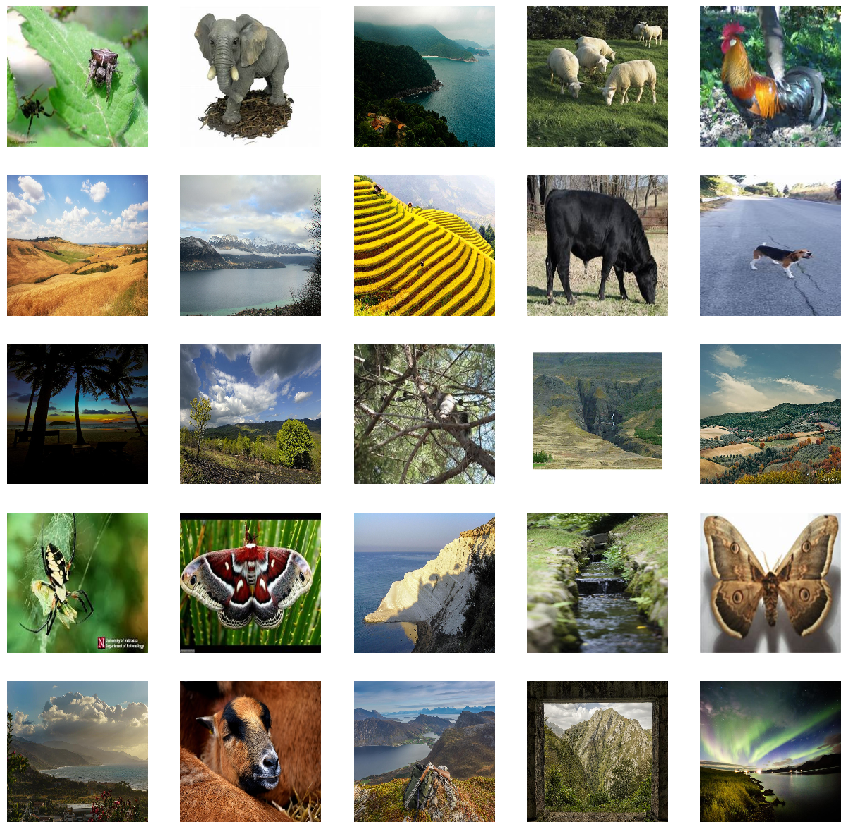

In [7]:
# display before gamma normalization to see what changed
displayImages(5, 5 , X_train, y_train)

In [8]:
# gamma normalization
def makeGammaTable(gamma): 
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return table

In [9]:
# apply gamma normalization
table = makeGammaTable(1.5)
for i in range(len(X_train)):
    X_train[i] = cv.LUT(X_train[i], table)

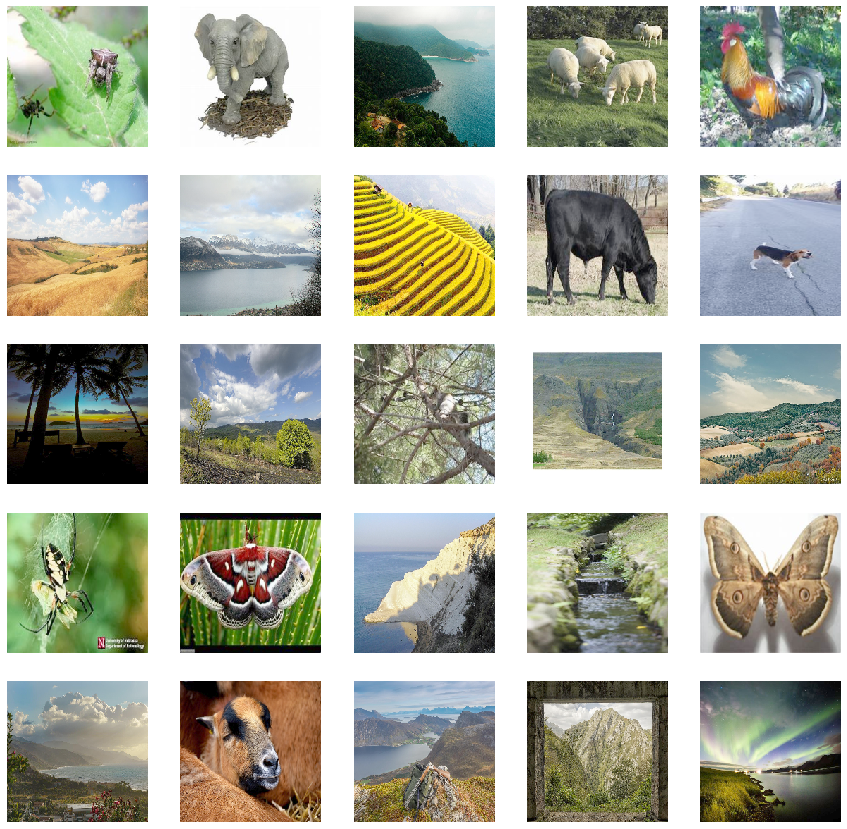

In [10]:
# display after gamma normalization
displayImages(5, 5 , X_train, y_train)

Good explaination of HoG:
https://stackoverflow.com/questions/32417531/hog-what-is-done-in-the-contrast-normalization-step

In [11]:
# images needs to be in grayscale, added conversion to this function to streamline it
# function computes gradient and orientation of each pixel 
def gradientImage(imageIn):
    image = cv.cvtColor(imageIn, cv.COLOR_BGR2GRAY)
    gradient = [] #[ [0] * (len(image[0]) - 2)] * (len(image) - 2)
    orientation = [] #[ [0] * (len(image[0]) - 2)] * (len(image) - 2)
    zeroRow = [0] * image.shape[1]
    gradient.append(zeroRow)
    orientation.append(zeroRow)
    
    for j in range(1,image.shape[0] - 1):
        g = []
        o = []
        g.append(0)
        o.append(0)
        
        for i in range (1, image.shape[1] - 1):
            x = int(image[j, i - 1]) - int(image[j, i + 1]) # using [1 0 -1] filter mask
            y = int(image[j + 1, i]) - int(image[j - 1, i]) 
            g.append(math.sqrt((x**2) + (y**2)))
            otemp = math.degrees(math.atan2(y, x))
            
            if otemp < 0: # force orientation range to acceptable [0,360] range, no negative degrees
                o.append(otemp + 360)
            else:
                o.append(otemp)
                
        g.append(0)
        o.append(0)
        gradient.append(g)
        orientation.append(o)
    gradient.append(zeroRow)
    orientation.append(zeroRow)
    return np.array(gradient), np.array(orientation)
            
# apply gradientImage to array of images
def gradientImages(images):
    gradients = []
    orientations = []
    for i in range(len(images)):
        g, o = gradientImage(images[i])
        gradients.append(g)
        orientations.append(o)
    return np.array(gradients), np.array(orientations)

Text(0.5, 1.0, 'Orientation')

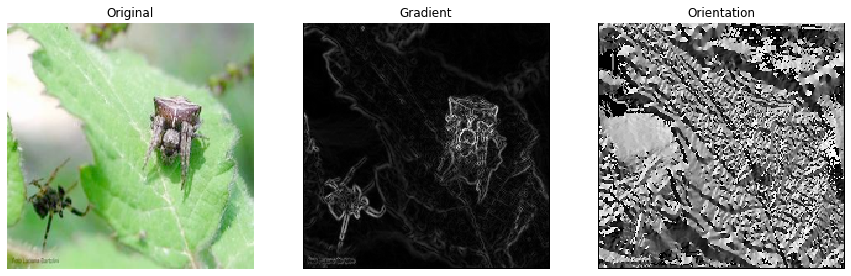

In [12]:
# testing gradientImage
g, o = gradientImage(X_train[0])
fig = plt.figure(figsize=(15, 15))

fig.add_subplot(1, 3, 1)
plt.imshow(X_train[0], cmap = "gray")
plt.axis('off')
plt.title("Original")

fig.add_subplot(1, 3, 2)
plt.imshow(g, cmap = "gray")
plt.axis('off')
plt.title("Gradient")

fig.add_subplot(1, 3, 3)
plt.imshow(o, cmap = "gray")
plt.axis('off')
plt.title("Orientation")

In [13]:
#testing gradientImages
gs, os = gradientImages(X_train[0:2])

(200, 200, 3)
(200, 200)
(200, 200)


Text(0.5, 1.0, 'Orientation')

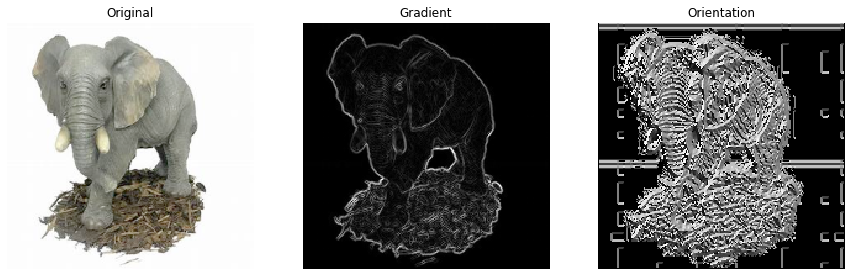

In [14]:
print(X_train[1].shape)
print(gs[1].shape)
print(os[1].shape)
fig = plt.figure(figsize=(15, 15))

fig.add_subplot(1, 3, 1)
plt.imshow(X_train[1], cmap = "gray")
plt.axis('off')
plt.title("Original")

fig.add_subplot(1, 3, 2)
plt.imshow(gs[1], cmap = "gray")
plt.axis('off')
plt.title("Gradient")

fig.add_subplot(1, 3, 3)
plt.imshow(os[1], cmap = "gray")
plt.axis('off')
plt.title("Orientation")

In [15]:
# given cell size and bin size, conducts binning for each cell in image at binSize intervals
# each pixel has weight equal to its gradient
def binningImage(gradient, orientation, cellX, cellY, binSize):
    thetas = np.arange(0, 360, step = binSize)
    votes = []
    
    for j in range(0, len(gradient) - cellY, cellY): # partitions each cell in Y direction
        voteRow = []
        
        for i in range (0, len(gradient[0]) - cellX, cellX):# partitions each cell in X direction
            votesPerCell = [0.0] * len(thetas)
            
            for l in range(j, j + cellY): # does binning within each cell
                
                for k in range(i, i + cellX):
                    binVal = orientation[l,k] - (orientation[l,k] % binSize)
                    idx = np.where(thetas == binVal)
                    votesPerCell[idx[0][0]] += gradient[l,k]
                    
            voteRow.append(votesPerCell)
            
        votes.append(voteRow)
    return np.array(votes)

# does binning for all images in given array
def binningImages(gs, os, cellX, cellY, binSize):
    votes = []
    for i in range(len(gs)):
        votes.append(binningImage(gs[i], os[i], cellX, cellY, binSize))
    return np.array(votes)

In [16]:
# testing binning Image
cellX = 5
cellY = 5
binSize = 20
votes = binningImage(gs[1], os[1], cellX, cellY, binSize)

#votesAll = binningImages(gs, os, cellX, cellY, binSize) # testing binningImages

In [17]:
print(votes.shape)
votes[0,0]

(39, 39, 18)


array([ 0.,  0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       16.,  0.,  0.,  0.,  0.])

In [18]:
"""
superimpose results from binning on top of its respective image
results depicted as lines from the center of the cell 
some basic normalization over entire image is done to make superimposed image more meaningful
otherwise, entire image might be covered with lines
this normalizing is only done for the purposes of visualization and doesn't affect the actual data
"""
def showBinning(image, votes, cellX, cellY):
    avg = np.average(votes)
    numOfBin = votes.shape[2]
    tempStep3 = image.copy()
    
    for j in range(votes.shape[0]):
        
        for i in range(votes.shape[1]): # for each cell
            startX = int(((cellX + 1) / 2) + (i * cellX)) # line starting from the center of the cells
            startY = int(((cellY + 1) / 2) + (j * cellY))
            
            # draw lines for each binned orientation of length equal to 
            # votes for that bin / average vote over entire image
            for b in range(votes.shape[2]): 
                if votes[j,i,b] > 0:
                    angle = b * (360 / numOfBin)
                    endX = int(startX + ((votes[j,i,b] / avg)  * math.cos(math.radians(angle))))
                    endY = int(startY + ((votes[j,i,b] / avg) * math.sin(math.radians(angle))))
                    cv.line(tempStep3, (startX,startY), (endX, endY), (255, 0, 0), 2)
                    
    fig = plt.figure(figsize=(15, 15))
    fig.add_subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')
    fig.add_subplot(1, 2, 2)
    plt.imshow(tempStep3)
    plt.axis('off')

Notice in the images below, cells that seem to be generally one color (likely with smaller gradients) and are not an edge of any kind seem to have equal binning in all orientation bins. This is shown as the superimposed lines for that in the right image looking almost like a circle. On the other hand, clear edges or boundries have more complex lines that cover much of the image in that cell.

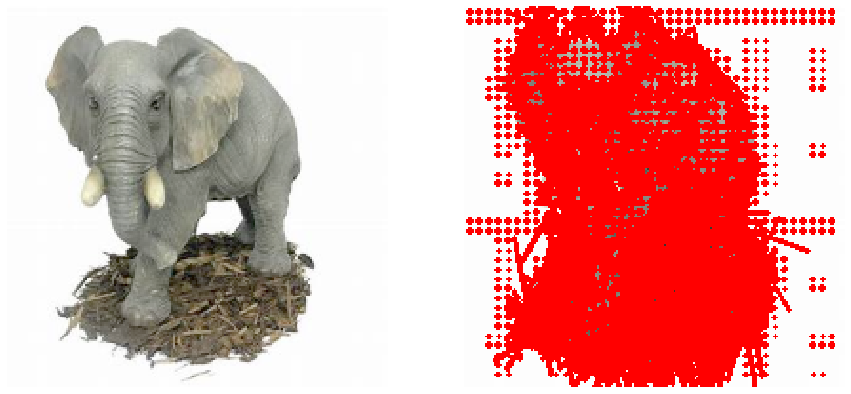

In [19]:
showBinning(X_train[1], votes, cellX, cellY) # for visualization purposes

In [20]:
# officially locally normalizing within each block of the image
# blocks should contain multiple cells and should overlap each other 
def descriptor(votes, blockX, blockY, overlapY, overlapX):
    blocks = []
    
    for j in range(0, len(votes) - blockY + 1, blockY - overlapY):
        blockRow = []
        
        for i in range(0, len(votes[0]) - blockX + 1, blockX - overlapX): # dividing the cells into there blocks
            block = votes [j:j + blockY, i:i + blockX]
            blockFlat = block.flatten()
            denom = 1
            
            for k in range(len(blockFlat)):
                denom += blockFlat[k]**2
                
            denom = math.sqrt(denom) # L2 norm
            block = block / denom
            blockRow.append(block)
            
        blocks.append(blockRow)
    return np.array(blocks)

#normalizing blocks over entire array
def descriptors(votes, blockX, blockY, overlapY, overlapX):
    blocks = []
    for i in range(len(votes)):
        blocks.append(descriptor(votes[i],blockX, blockY, overlapY, overlapX))
    return np.array(blocks)

In [21]:
blockX = 2
blockY = 2
overlapX = 1
overlapY = 1
blocks = descriptor(votes, blockX, blockY, overlapY, overlapX)

In [22]:
print(blocks.shape) # confirm size

(38, 38, 2, 2, 18)


In [23]:
""" 
create two versions of the final HOG descriptor
    - one for visualization purposes superimposed on top of the original image
    - another that is just the HOG Descriptor in black and white that will be used for classification
"""
def drawHOGDescriptor(image, blocks, cellX, cellY, blockX, blockY, overlapY, overlapX):
    numOfBins = blocks.shape[4]
    tempStep4 = image.copy() 
    imageBW = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    tempStep4BW = np.zeros(imageBW.shape)
    
    for j in range(blocks.shape[0]): # for each block
        for i in range(blocks.shape[1]):
            startX = int((((cellX * blockX) + 1) / 2) + (i * cellX * (blockX - overlapX))) 
            startY = int((((cellY * blockY) + 1) / 2) + (j * cellY * (blockY - overlapY)))
            
            for l in range(blocks.shape[2]): # for each cell within the block
                for k in range(blocks.shape[3]):
                    
                    # for each bin within the cell, draw a line from the center of the cell
                    for b in range(blocks.shape[4]): 
                        angle = b * (360 / numOfBins)
                        endX = int(startX + ((blocks[j,i,l,k,b] * 10)  * math.cos(math.radians(angle))))
                        endY = int(startY + ((blocks[j,i,l,k,b] * 10) * math.sin(math.radians(angle))))
                        cv.line(tempStep4, (startX,startY), (endX, endY), (255, 0, 0), 1)
                        cv.line(tempStep4BW, (startX,startY), (endX, endY), 255, 1)
                        
    return tempStep4, tempStep4BW                
    
# draws HOG descriptor on entire array of images
def drawHOGDescriptors(images, blocks, cellX, cellY, blockX, blockY, overlapY, overlapX):
    img = []
    imgBW = []
    for i in range(len(images)):
        c, b = drawHOGDescriptor(images[i], blocks[i], cellX, cellY, blockX, blockY, overlapY, overlapX)
        img.append(c)
        imgBW.append(b)
    return np.array(img), np.array(imgBW)

Image on left is the original image with the HOG descriptor superimposed on it. The image on the right is just the HOG Desriptor which we will be using for classificiation.

(-0.5, 199.5, 199.5, -0.5)

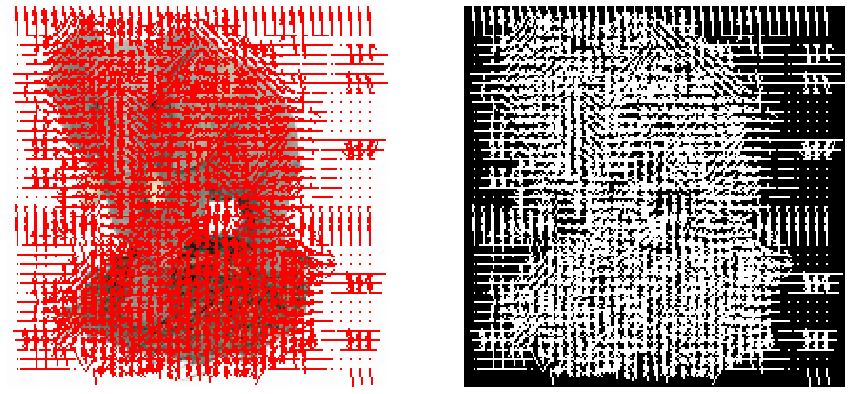

In [24]:
c,b = drawHOGDescriptor(X_train[1], blocks, cellX, cellY, blockX, blockY, overlapY, overlapX)
fig = plt.figure(figsize=(15, 15))
fig.add_subplot(1, 2, 1)                                        
plt.imshow(c)
plt.axis('off')
fig.add_subplot(1, 2, 2)
plt.imshow(b, cmap='gray')
plt.axis('off')

In [25]:
gs, os = gradientImages(X_train)

In [26]:
votes = binningImages(gs, os, cellX, cellY, binSize)

In [27]:
blocks = descriptors(votes, blockX, blockY, overlapY, overlapX)

In [28]:
c,b = drawHOGDescriptors(X_train, blocks, cellX, cellY, blockX, blockY, overlapY, overlapX)

In [29]:
# repeat for validation
gsv, osv = gradientImages(X_val)
votesv = binningImages(gsv, osv, cellX, cellY, binSize)
blocksv = descriptors(votesv, blockX, blockY, overlapY, overlapX)
csV,bv = drawHOGDescriptors(X_val, blocksv, cellX, cellY, blockX, blockY, overlapY, overlapX)

In [30]:
trainb = []
for i in range(len(b)):
    trainb.append(b[i].flatten())
print(np.array(trainb).shape)

(800, 40000)


In [31]:
valb = []
for i in range(len(bv)):
    valb.append(bv[i].flatten())
print(np.array(valb).shape)

(100, 40000)


## Starting to classify here!

In [32]:
#best case!
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

sgd_clf = SGDClassifier(loss='log', max_iter=1000,  random_state=0)
sgd_clf.fit(trainb, y_train)
cross_val_score(sgd_clf, valb, y_val, cv=3, scoring="accuracy")

array([0.85294118, 0.81818182, 0.81818182])

In [33]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_depth=2, random_state=0)
rf_clf.fit(trainb, y_train)
cross_val_score(rf_clf, valb, y_val, cv=3, scoring="accuracy")

/Users/nittupatel/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([0.47058824, 0.66666667, 0.6969697 ])

In [34]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(n_estimators=100, random_state=0)
ada_clf.fit(trainb, y_train)
cross_val_score(ada_clf, valb, y_val, cv=3, scoring="accuracy")

array([0.73529412, 0.6969697 , 0.72727273])

In [35]:
from sklearn.svm import SVC

svc_clf = SVC(gamma="auto", random_state=0, kernel='linear')
svc_clf.fit(trainb, y_train)
cross_val_score(svc_clf, valb, y_val, cv=3, scoring="accuracy")

array([0.82352941, 0.87878788, 0.87878788])

In [36]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=7)
knn_clf.fit(trainb, y_train)
cross_val_score(knn_clf, valb, y_val, cv=3, scoring="accuracy")

array([0.55882353, 0.63636364, 0.54545455])

In [37]:
gst, ost = gradientImages(X_test)
votest = binningImages(gst, ost, cellX, cellY, binSize)
blockst = descriptors(votest, blockX, blockY, overlapY, overlapX)
ct,bt = drawHOGDescriptors(X_test, blockst, cellX, cellY, blockX, blockY, overlapY, overlapX)

In [38]:
testb = []
for i in range(len(bt)):
    testb.append(bt[i].flatten())
print(np.array(testb).shape)

(100, 40000)


In [39]:
from sklearn.metrics import accuracy_score

y_pred = sgd_clf.predict(testb)
accuracy_score(y_test, y_pred)

0.87